In [1]:
#check here at Xe data: integ_wf = -1.*wf_led[ch][:, integ_range_idx[0]:integ_range_idx[1]].sum(axis=1)

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 


In [2]:
labels = ['H11901P-04', 'H11901P-04 (fibre swapped)']

wavelength = [400, 400]

files = [
    [
    '../../data/2024-02-28_Xe/CH2_H11901P-04_1.08v_400nm_wforms.feather',
    '../../data/2024-02-28_Xe/CH2_H11901P-04_1.08v_400nm_mid_luminousity_wforms.feather'
    ],
    [
    '../../data/2024-02-28_Xe/CH2_H11901P-04_1.08v_400nm_another_exit_wforms.feather',
    '../../data/2024-02-28_Xe/CH2_H11901P-04_1.08v_400nm_another_exit_mid_luminousity_wforms.feather'
    ]
]

In [3]:
tres=4. #4 ns
vres=2.0/(2**12)*1000. #mV
#labels=['PN2304-1470', 'H11901P-04']
#data=pd.read_feather('./data/2024-02-16_Xe/CH0_HAM_KM56206_1058v_CH1_H11901P-04_1.08v_400nm_50Hz_wforms.feather')
#data

In [4]:
wf = []
for i in range(len(wavelength)):
    for j in range(len(files)):
        df = pd.read_feather(files[j][i])
        wf.append(np.vstack(df['2'].values)*vres)
len(wf)

4

In [5]:
print(wf[0].shape)

(10005, 2048)


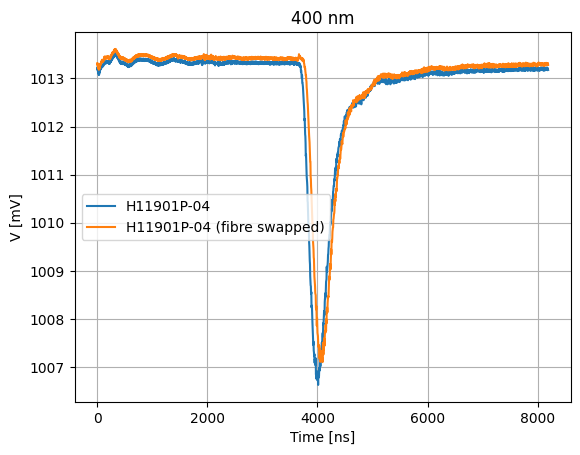

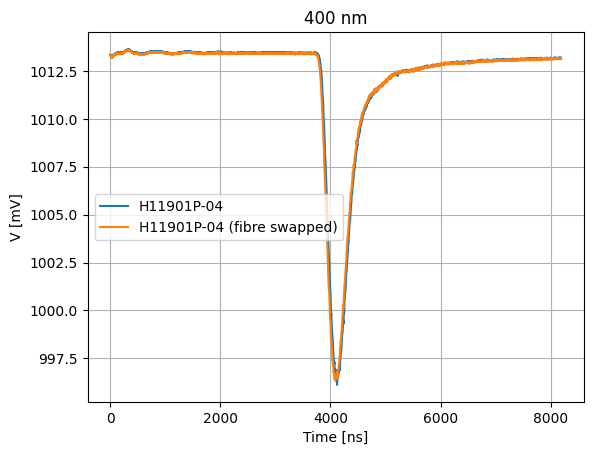

In [6]:
time=np.array([i*tres for i in range(wf[0].shape[1])])

for i in range(len(wavelength)):
    n=len(labels)
    for ch in range(n):
        plt.title('{:d} nm'.format(wavelength[i]))
        plt.plot(time, wf[i*n+ch].mean(axis=0), label=labels[ch])
    plt.grid()
    plt.ylabel('V [mV]')
    plt.xlabel('Time [ns]')
    plt.legend()
    plt.show()

In [7]:
for i in range(len(files[0])):
    n=len(labels)
    for ch in range(n):
        head = wf[i*n+ch][:,500:875] # 2000:3500 ns
        #baseline = head[(head[:,-1]<(head.mean(axis=1)+head.std(axis=1)*10)) * (head[:,-1]>(head.mean(axis=1)-head.std(axis=1)*10))].mean(axis=1)
        baseline = head.mean(axis=1)
        wf[i*n+ch] = wf[i*n+ch] - baseline[:,None]

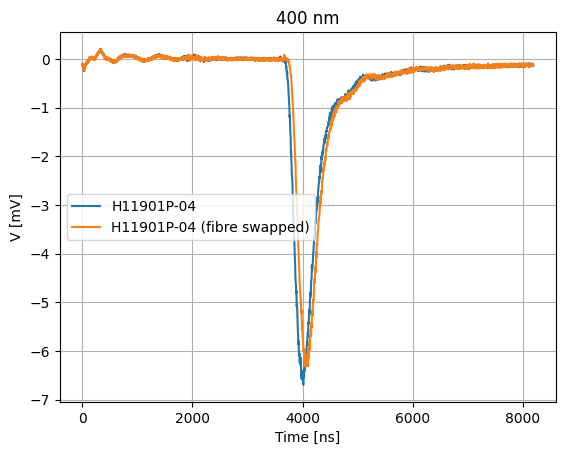

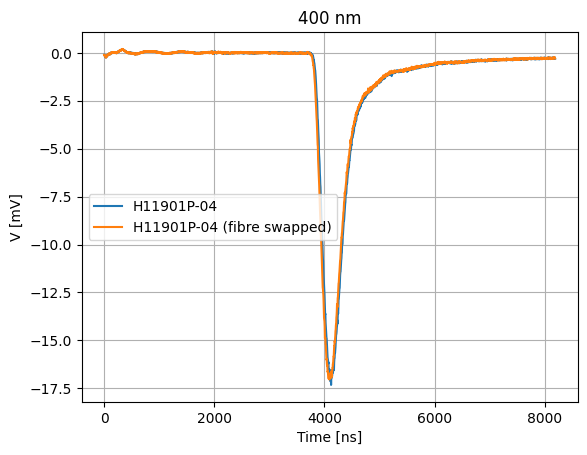

In [8]:
average_wf = []
for i in range(len(wavelength)):
    n=len(labels)
    for ch in range(n):
        average_wf.append(wf[i*n+ch].mean(axis=0))
        plt.title('{:d} nm'.format(wavelength[i]))
        plt.plot(time, wf[i*n+ch].mean(axis=0), label=labels[ch])
    
    plt.grid()
    plt.ylabel('V [mV]')
    plt.xlabel('Time [ns]')
    plt.legend()
    plt.show()

/tmp/ipykernel_3069115/849843498.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


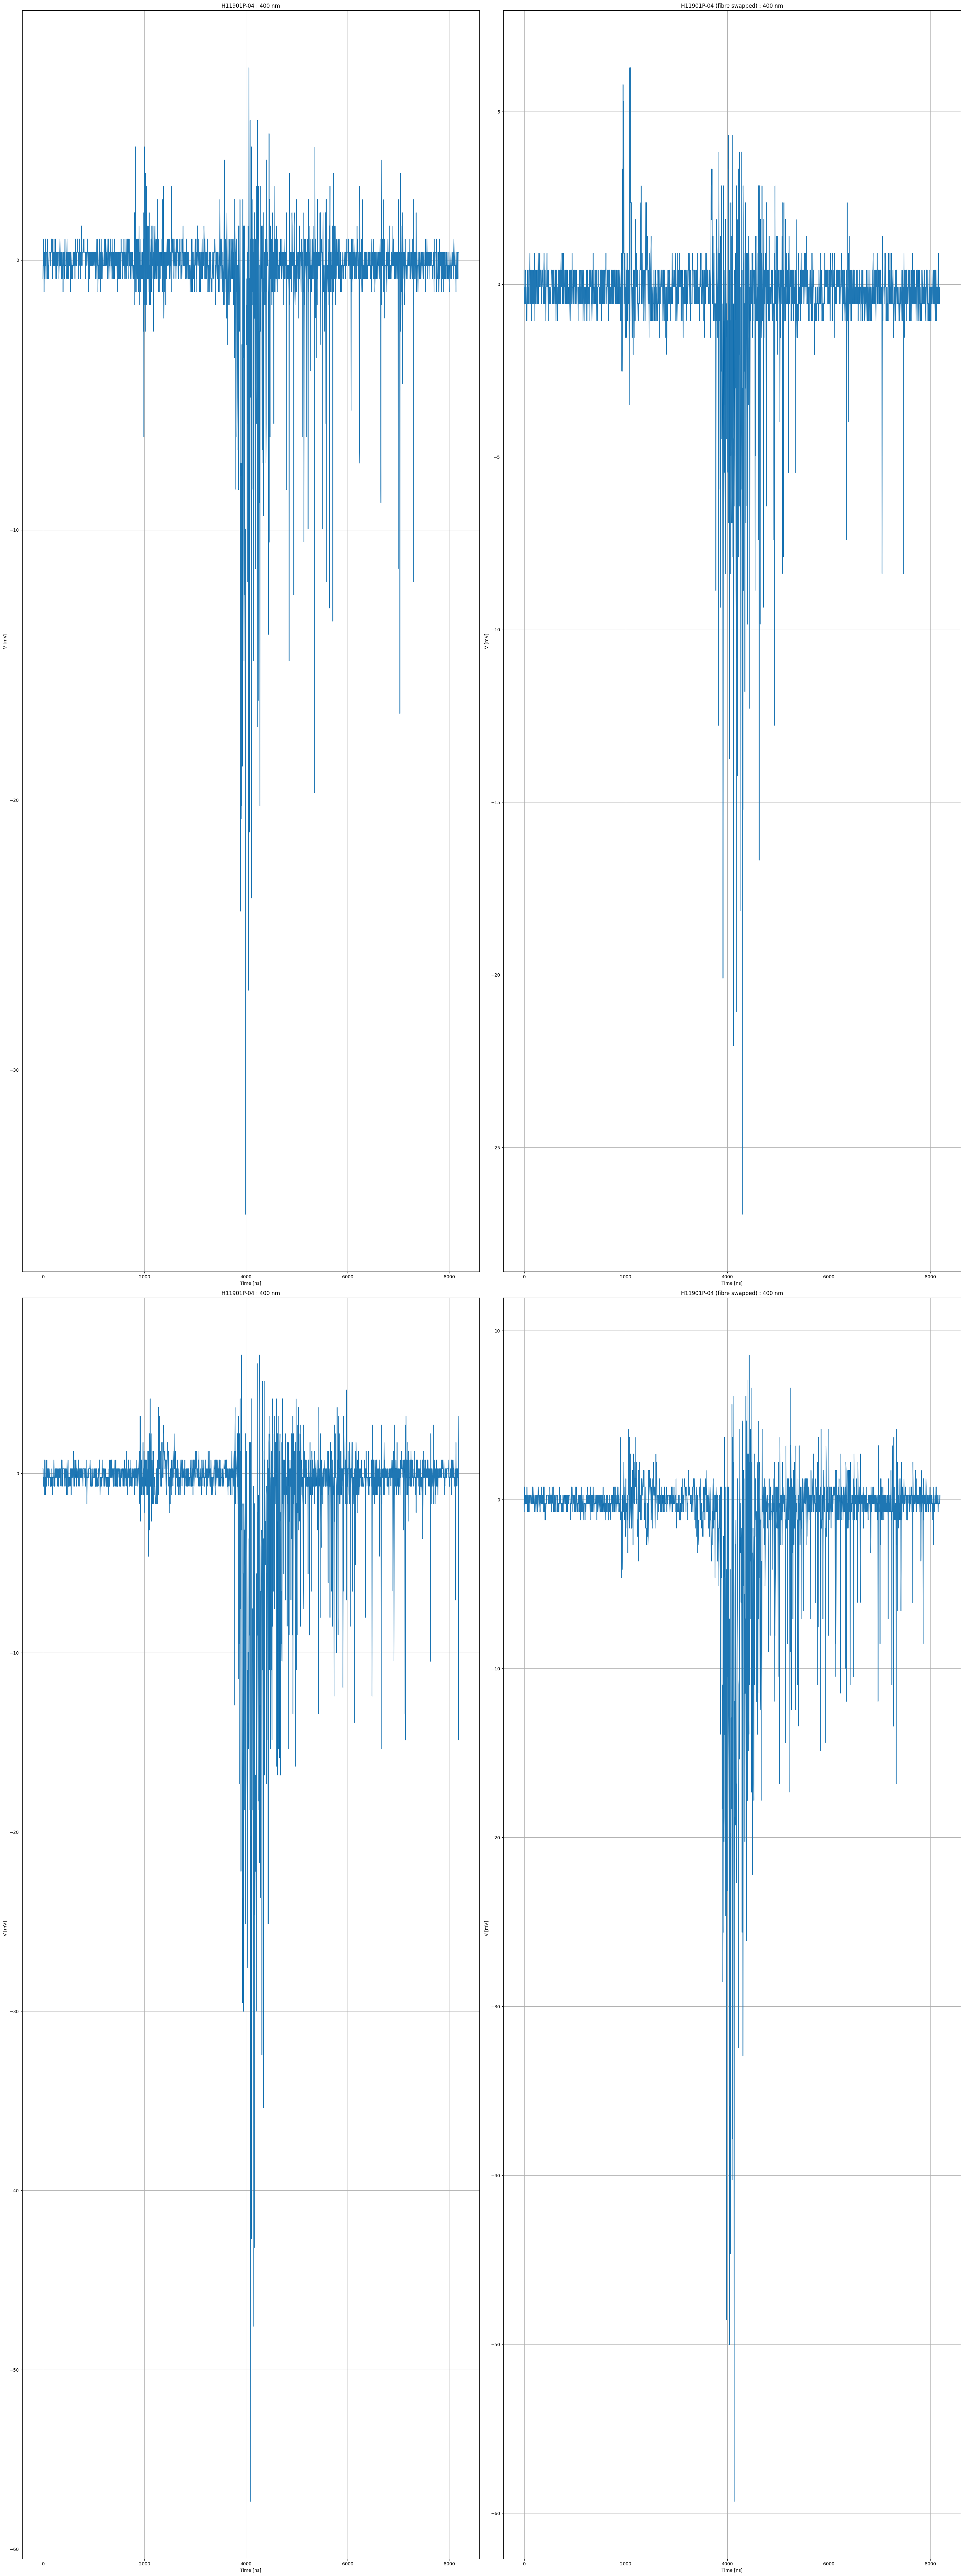

In [9]:
fig, ax = plt.subplots(len(wavelength), len(labels), figsize=[30,80])
for i in range(len(wavelength)):
    n=len(labels)
    for ch in range(n):
        title=labels[ch]+' : '+str(wavelength[i])+' nm'
        ax[i,ch].set_title(title)
        ax[i,ch].plot(time, wf[i*n+ch][0]) # 1st wf
        ax[i,ch].set_xlabel('Time [ns]')
        ax[i,ch].set_ylabel('V [mV]')
        ax[i,ch].grid()
fig.tight_layout()
fig.show()

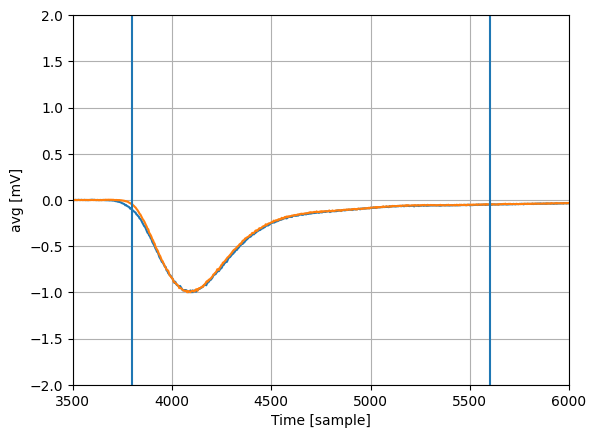

In [10]:
n=len(labels)
average_all_wf = []
for ch in range(len(labels)):
    average_all_wf.append([ average_wf[i*n+ch] for i in range(len(wavelength)) ])
for ch in range(len(labels)):
    average_all_wf[ch] = np.vstack(average_all_wf[ch]).mean(axis=0)
    plt.plot(time, -1*average_all_wf[ch]/average_all_wf[ch].min(), label=labels[ch])
    
plt.axvline(3800) # start ref. +80 for 3inch pmt
plt.axvline(5600) #nnvt
plt.axvline(2100) #hpk
plt.ylabel('avg [mV]')
plt.xlabel('Time [sample]')
plt.ylim([-2, 2])
plt.xlim([3500,6000])
plt.grid()
#plt.legend(loc='lower right')
plt.show()

In [17]:
integ_ranges = []

tmp_cut = [3500, 6000]
n=len(labels)
for i in range(0,len(wavelength)):
    for ch in range(n):
        #print(i,ch)
        avg_wf=wf[i*n+ch].mean(axis=0)[int(tmp_cut[0]/tres) : int(tmp_cut[1]/tres) ]

        peak_i = avg_wf.argmin()
        pre_peak = avg_wf[:peak_i]
        pro_peak = avg_wf[peak_i:]
        peak = avg_wf.min()

        rising = np.argwhere(pre_peak>0.1*peak)[-1][0]
        falling= np.argwhere(pro_peak>0.75*peak)[0][0] if not np.isnan(np.argwhere(pro_peak>0.1*peak).mean()) else 5000 # tmp
        #falling= 0 #peak
    
        print(i,ch)
        integ_ranges.append( [tmp_cut[0]+rising*tres, tmp_cut[0]+(falling+peak_i)*tres] )

0 0
0 1
1 0
1 1


In [16]:
print(len(integ_ranges)), integ_ranges

4


(None,
 [[3744.0, 4132.0], [3804.0, 4208.0], [3848.0, 4256.0], [3828.0, 4244.0]])

In [25]:
integ_ranges = [
    [3600,4500],[3600,4500],
    [3600, 4500],[3600,4500]
]

0 0 2
1 1 3


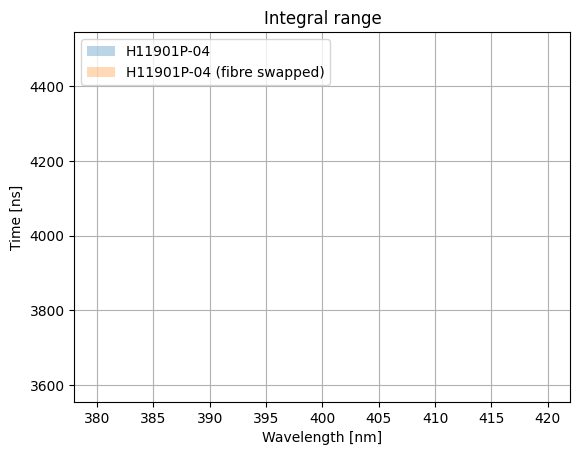

In [26]:
n=len(labels)
for ch in range(n):
    print(ch, 0*n+ch, 1*n+ch)
    integ_range_select_ch = np.vstack([ integ_ranges[i*n+ch] for i in range(len(wavelength)) ] )
    plt.fill_between(wavelength, integ_range_select_ch[:,0], integ_range_select_ch[:,1], alpha=0.3, label=labels[ch])

plt.title('Integral range')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Time [ns]')
plt.grid()
plt.legend(loc='upper left')
plt.show()

In [23]:
def gaussian(x, amp, loc, sig):
    return amp*np.exp(-np.power(x - loc, 2.) / (2 * np.power(sig, 2.)))

[3600, 4500]
mean, std 702.9546448661961 91.77100683807221
[3600, 4500]
mean, std 656.7592276288658 90.51486169528592


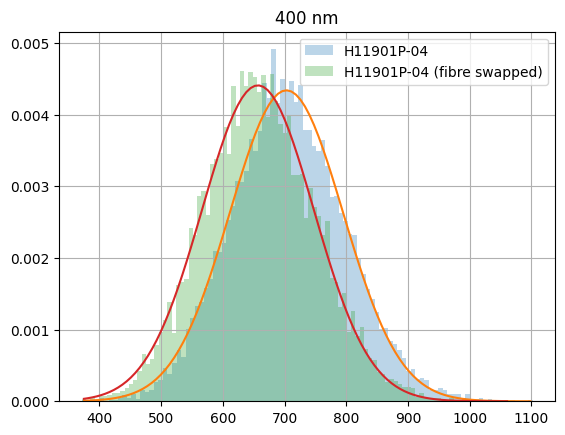

[3600, 4500]
mean, std 1761.3341051705074 141.38331230143956
[3600, 4500]
mean, std 1794.9895528558136 143.56975418338394


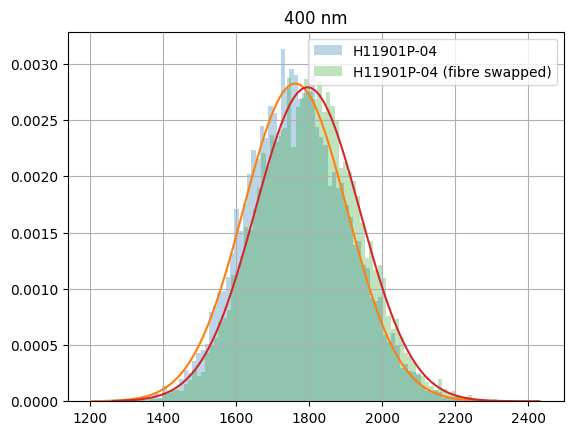

In [31]:
#integ_ranges = [[4000,4800], [3920,4720],
#                [3920,4720], [3840,4640],
#                [4000,4800], [3920,4720],
#                [4000,4800], [3920,4720]
#               ]

mean_integ_wf = []
std_integ_wf = []
mean_gaus_integ_wf = []
std_gaus_integ_wf = []

for i in range(len(wavelength)):
    n=len(labels)
    for ch in range(n):
        #if ch%2 == 0:
        #    integ_range = integ_range_3inch
        #else:
        #    integ_range = integ_range_ref
        integ_range = integ_ranges[i*n+ch]
        print(integ_range)
        
        integ_range_idx = [ int(integ_range[0]/tres), int(integ_range[1]/tres) ]
        #integ_range_idx = integ_range
        integ_wf = -1.*wf[i*n+ch][:,integ_range_idx[0]:integ_range_idx[1]].sum(axis=1)
        mean_integ_wf_tmp = integ_wf.mean()
        std_integ_wf_tmp = integ_wf.std()
        mean_integ_wf.append(mean_integ_wf_tmp)
        std_integ_wf.append(std_integ_wf_tmp)

        plt.title('{:d} nm'.format(wavelength[i]))
        histogram = plt.hist(integ_wf, bins=100, label=labels[ch], alpha=0.3, density=True)

        x_hist = (histogram[1][1:]+histogram[1][0:-1])/2.0
        y_hist = histogram[0]
        p0=[y_hist.max(), mean_integ_wf_tmp, std_integ_wf_tmp]
        p, pconv = curve_fit(gaussian, x_hist, y_hist, p0=p0) #sigma=sigma, bounds=bounds)
        mean_integ_wf_tmp = p[1]
        std_integ_wf_tmp = p[2]
        mean_gaus_integ_wf.append(mean_integ_wf_tmp)
        std_gaus_integ_wf.append(std_integ_wf_tmp)
        
        print('mean, std', mean_integ_wf_tmp, std_integ_wf_tmp)
        fit=gaussian(x_hist,p[0],p[1],p[2])
        plt.plot(x_hist, fit)
    
    plt.grid()
    plt.legend()
    plt.show()


In [ ]:
def calc_err(x, y, method='+'):
    z = 0.
    zerr = 0.

    if method == '+':
        z = x[0] + y[0]
        zerr = np.sqrt(x[1]**2 + y[1]**2)
    if method == '-':
        z = x[0] - y[0]
        zerr = np.sqrt(x[1]**2 + y[1]**2)
    if method == '*':
        z = x[0] * y[0]
        zerr = np.sqrt( (x[0]*y[1])**2 + (y[0]*x[1])**2 )
    if method == '/':
        z = x[0] / y[0]
        zerr = np.sqrt( (x[1]/y[0])**2 + ((x[0]*y[1])/(y[0]**2))**2 )

    return [z, zerr]